In [1]:
import numpy as np
import gbd
import raytrace as rt
import utils as ut
from scipy.io import loadmat
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
from IPython.display import Audio
import poppy
import astropy.units as u
sound_file = './sound/beep.wav'

def filter_offdiagonal_abcd(ABCD):
    
    # A Submatrix
    ABCD[0,1,:] = 0
    ABCD[1,0,:] = 0
    
    # B Submatrix
    ABCD[0,3,:] = 0
    ABCD[1,2,:] = 0
    
    # C Submatrix
    ABCD[2,1,:] = 0
    ABCD[3,0,:] = 0
    
    # D Submatrix
    ABCD[2,3,:] = 0
    ABCD[3,2,:] = 0
    
    return ABCD

def diagonalize_abcd(ABCD):
    
    from numpy.linalg import eig,inv
    
    abcd_box = np.zeros(ABCD.shape)
    
    for i in range(ABCD.shape[-1]):
        
        evals,evecs = eig(ABCD[:,:,i])
        abcd_box[:,:,i] = inv(evecs) @ ABCD[:,:,i] @ evecs
        
    return abcd_box

numexpr sees numcores =  8
numexpr sees numthreads =  8
numexpr sees max threads =  96
numba threads =  8


In [156]:
# set up optical system
wl = 1.65e-6
npix = 256
size = 2.4
# 0.02024
# set up detector
dsize = 4.95e-6*256 #1.22*wl*(57.6/2.4)*25
x = np.linspace(-dsize/2,dsize/2,npix)
x,y = np.meshgrid(x,x)

# set up gaussian
# wo = 9200*wl
wo = 12300*wl
zr = np.pi * wo**2 / wl # meters
q  = 1j*zr
qinv = 1/q
k = 2*np.pi/wl

# an orthogonal beamlet
Qinv = np.array([[qinv,0],
                 [0,qinv]])

print('wo = ',wo,' [m]')

wo =  0.020295  [m]


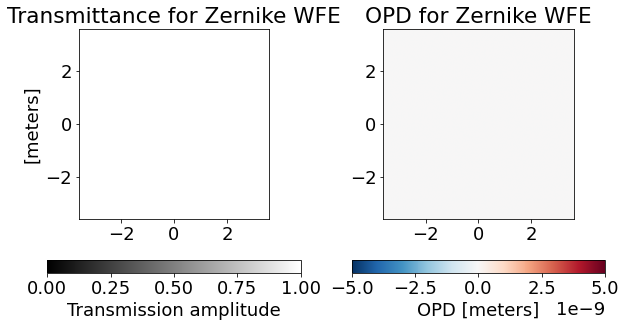

(<AxesSubplot:title={'center':'Wavefront amplitude'}, xlabel='m', ylabel='m'>,
 <AxesSubplot:title={'center':'Wavefront phase'}, xlabel='m'>)

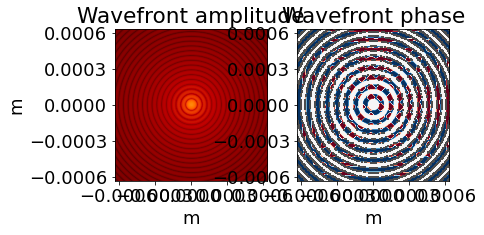

In [158]:
efl = 57.6

# Set up and propagate Fresnel
wf = poppy.FresnelWavefront(size/2*u.m,wavelength=wl,npix=npix,oversample=8)
circ = poppy.CircularAperture(radius=size/2*u.m)
#pwfe = poppy.ArrayOpticalElement(transmission=np.ones(phase.shape),opd=phase,pixelscale=wf.pixelscale)
amount = 1*2.2e-10
pwfe = poppy.ZernikeWFE(coefficients=[0,0*2.2e-6,0,
                                            0*amount,
                                            0*amount,
                                            0*amount,
                                            0*amount,
                                            0*amount,
                                            0*amount],radius=size*u.m)
thin = poppy.QuadraticLens(efl*u.m)

# Grab applied WFE
opd_to_pass = ut.grab_center(pwfe.get_opd(wf),npix/2)

plt.figure(figsize=[10,5])
pwfe.display(what='both',opd_vmax=50e-10)
plt.show()

# Propagate
wf *= pwfe
wf *= circ
wf *= thin

wf.propagate_fresnel(efl)

wf.display(what='both',scale='log',imagecrop=dsize)

In [4]:
# create rayset
# 9200wl is to fit to the Zemax data set
rays = gbd.ComputeRaysFromOF(1.7,size,wo)
print('nrays = ',rays.shape[1])

# Artificial ABCD appears to work as expected!
efl = 57.6
dis = 57.6
abcd = np.array([[1-dis/efl + 1e-20,0,dis,0],
                 [0,1-dis/efl + 1e-20,0,dis],
                 [-1/efl,0,1,0],
                 [0,-1/efl,0,1]])

abcd_box = np.zeros([4,4,rays.shape[1]])

for ijk in range(rays.shape[1]):
    
    abcd_box[:,:,ijk] = abcd
    
ABCD = abcd_box

# Interpolate OPD
opd_interp = zoom(opd_to_pass,101/npix,order=3)

# Create Array from Wavefront Error that's about the same size
rays_aberrated = rt.ArbitraryWFE(rays.shape[1],size,rays,1/2,array=opd_interp)

# filter outside of circle - nonparaxial zemax data
ABCD = ABCD[:,:,np.sqrt(rays[0,:]**2 + rays[1,:]**2) <= (1.2-wo/4)]
rays_aberrated = rays_aberrated[:,np.sqrt(rays[0,:]**2 + rays[1,:]**2) <= (1.2-wo/4)]

# filter erroneous rays with some tolerance
raysout = rt.matmultrays(ABCD,rays_aberrated)
tol = 1e-4

# The centroid (kinda)
mean_r = np.mean(np.sqrt(raysout[0,:]**2 + raysout[1,:]**2))

# ABCD = ABCD[:,:,np.sqrt(raysout[0,:]**2 + raysout[1,:]**2) >= (tol)]
# rays_aberrated = rays_aberrated[:,np.sqrt(raysout[0,:]**2 + raysout[1,:]**2) >= (tol)]

nrays =  10201
Computing Derivative for Pixelscale of =  0.000235271051857661


In [5]:
np.sqrt(raysout[0,-5]**2 + raysout[1,-5]**2)

1.1799118611150579e-20

In [6]:
field = gbd.EvalGausslets(x,y,rays_aberrated,Qinv,k,ABCD,npix)
# field = gbd.eval_gausfield(rays_aberrated,ABCD,wl,dsize,npix,use_numexpr=True)

Number of Gausslets =  7793
finished tracing  7792  Gausslets


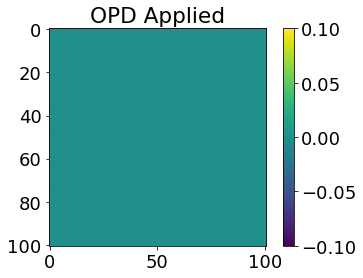

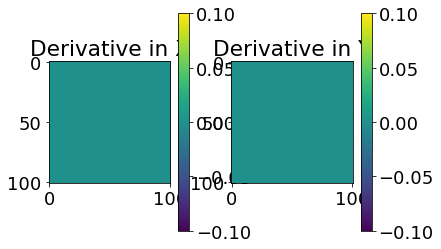

0.0

In [7]:
plt.figure()
plt.title('OPD Applied')
plt.imshow(opd_interp)
plt.colorbar()
plt.show()

# Compute Derivative of OPD
dx,dy = np.gradient(opd_interp,size/npix)

plt.figure()
plt.subplot(121)
plt.title('Derivative in X')
plt.imshow(dx)
plt.colorbar()
plt.subplot(122)
plt.title('Derivative in Y')
plt.imshow(dy)
plt.colorbar()
plt.show()

dy[51,51]

In [8]:
efie_numerical = field
wf.pixelscale

<Quantity 4.95e-06 m / pix>

<Figure size 432x288 with 0 Axes>

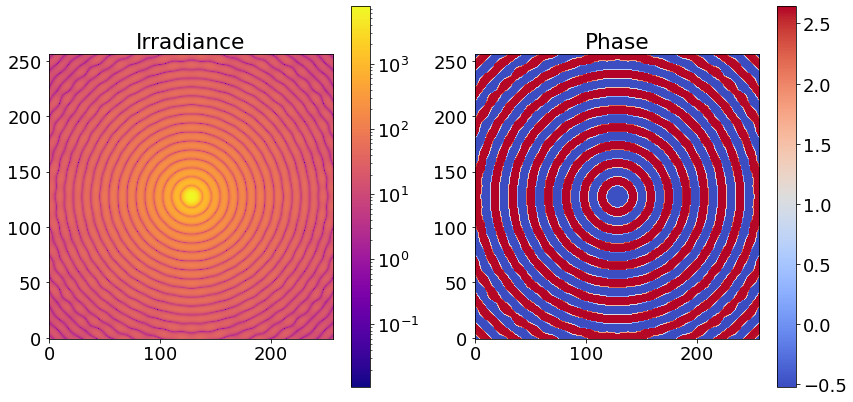

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

In [9]:
irrad = np.abs(field*np.conj(field))
phase = np.angle(field)

ut.amp_phase_plot(field,logintensity=True)

plt.figure(figsize=[10,5])


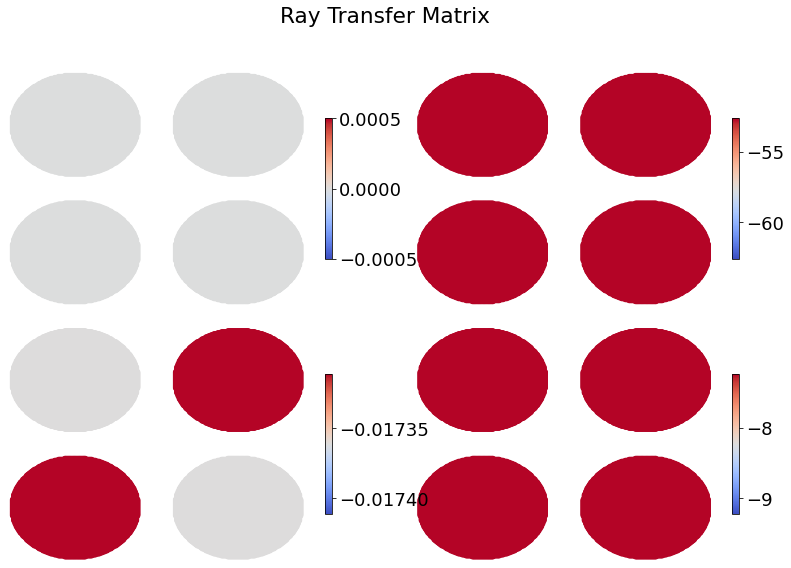

array([[[ 1.00000000e-20],
        [ 0.00000000e+00],
        [ 5.76000000e+01],
        [ 0.00000000e+00]],

       [[ 0.00000000e+00],
        [ 1.00000000e-20],
        [ 0.00000000e+00],
        [ 5.76000000e+01]],

       [[-1.73611111e-02],
        [ 0.00000000e+00],
        [ 1.00000000e+00],
        [ 0.00000000e+00]],

       [[ 0.00000000e+00],
        [-1.73611111e-02],
        [ 0.00000000e+00],
        [ 1.00000000e+00]]])

In [10]:
import importlib
importlib.reload(ut)
ut.fourbyfour(ABCD,rays_aberrated[0,:],rays_aberrated[1,:],size=1)

ABCD[:,:,rays_aberrated[0,:]**2 + rays_aberrated[1,:]**2 == 0]

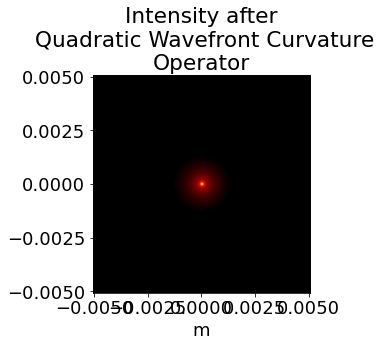

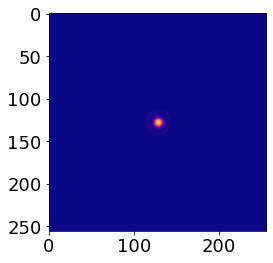

0.009854337620622846
0.0012666968389915757
1.0


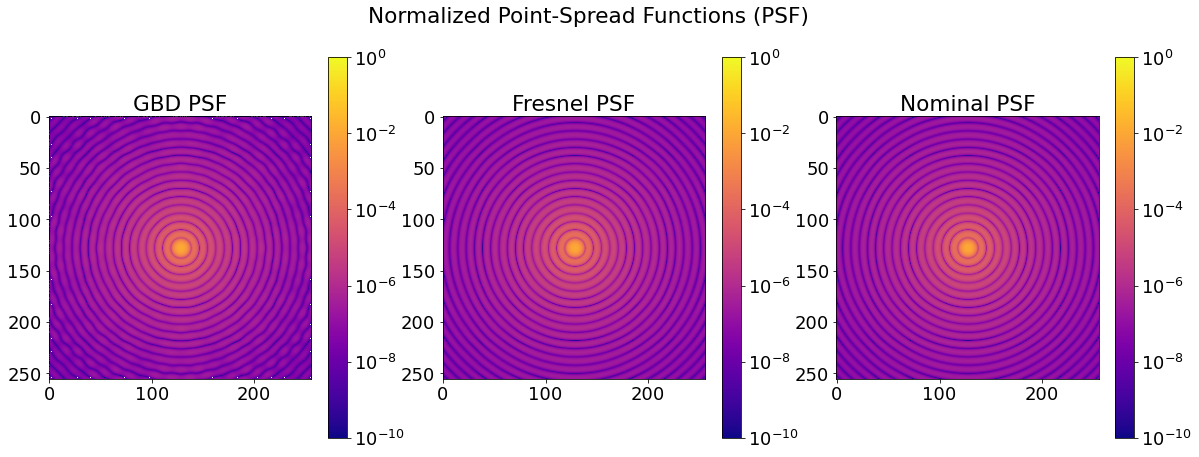

<ipython-input-183-456bf19a1a28>:89: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  fig = plt.imshow(difgbd,norm=norm,vmin=vmin,vmax=vmax)
<ipython-input-183-456bf19a1a28>:95: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  fig = plt.imshow(diffnl,norm=norm,vmin=vmin,vmax=vmax)


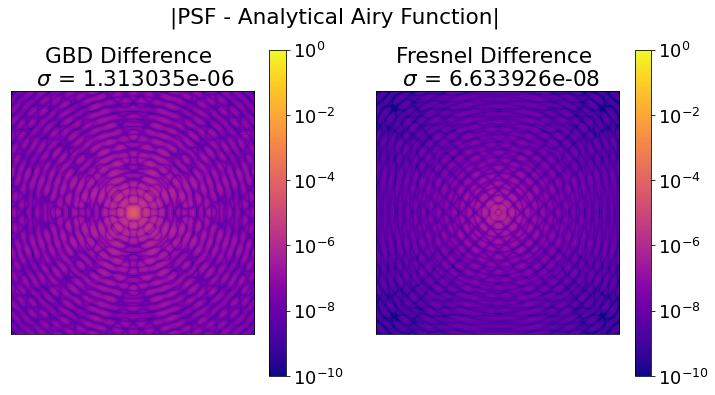

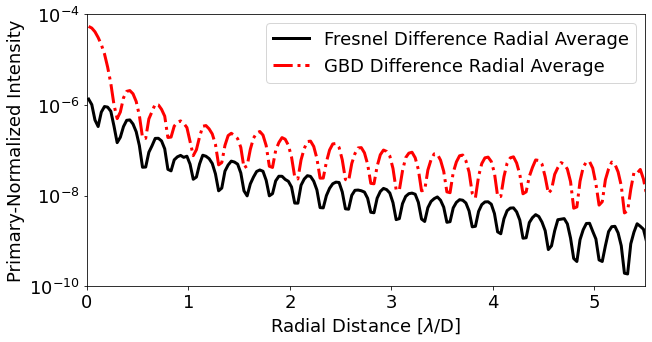

In [183]:
from scipy.ndimage import shift
from matplotlib.colors import LogNorm
from astropy.io import fits

wf.display(scale='log')

# grab PSF center
efie_fresnel = ut.grab_center(wf.wavefront,npix/2)
vmin = 1e-10
vmax = 1
pixscal = 4.95e-6
norm = LogNorm(vmin=vmin,vmax=vmax)


def ComputeIntensity(array):
    return np.abs(array*np.conj(array))

def array2poppyhdul(array,pixscal):
    
    from astropy.io import fits
    phdu = fits.PrimaryHDU(array)
    hdul = fits.HDUList([phdu])
    hdul[0].header['PIXELSCL'] = pixscal/4
    
    return hdul

# Primary-normalize the PSFs
fnlpsf = shift(ComputeIntensity(efie_fresnel),[0,0])
fnlpsf /= np.sum(fnlpsf)
gbdpsf = shift(ComputeIntensity(efie_numerical),[0.5,0.5])
gbdpsf /= np.sum(gbdpsf)

# Load nominal PSFs
METER2ARCSEC = 1/57.6 * 206265
nominal = poppy.misc.airy_2d(diameter=2.4, 
                             wavelength=wl,
                              shape=(256,256),
                             pixelscale=4.95e-6*METER2ARCSEC,
                             center=[128,128])

# nominal = ComputeIntensity(nominal)

plt.figure()
plt.imshow(nominal)
plt.show()

nominal /= np.sum(nominal)
gbdpsf_nominal = nominal #fits.open('psf_gbd_2.2um_2.4m.fits')[0].data
fnlpsf_nominal = nominal #fits.open('psf_fnl_2.2um_2.4m.fits')[0].data

# Compute % Difference
difgbd = np.abs(gbdpsf_nominal-gbdpsf)
diffnl = np.abs(fnlpsf_nominal-fnlpsf)
difdif = np.abs(diffnl-difgbd)

print(np.sum(difgbd))
print(np.sum(diffnl))
print(np.sum(nominal))

# Get profile of the aberrated residuals
gbd_pro = poppy.radial_profile(array2poppyhdul(difgbd,pixscal))
fnl_pro = poppy.radial_profile(array2poppyhdul(diffnl,pixscal))
dif_pro = poppy.radial_profile(array2poppyhdul(difdif,pixscal))



plt.figure(figsize=[20,7])
plt.set_cmap('plasma')
plt.suptitle('Normalized Point-Spread Functions (PSF)')
plt.subplot(131)
plt.title('GBD PSF')
plt.imshow(gbdpsf,norm=norm)
plt.colorbar()
plt.subplot(132)
plt.title('Fresnel PSF')
plt.imshow(fnlpsf,norm=norm)
plt.colorbar()
plt.subplot(133)
plt.title('Nominal PSF')
plt.imshow(nominal,norm=norm)
plt.colorbar()
plt.show()

plt.figure(figsize=[12,6])
plt.set_cmap('plasma')
plt.suptitle('|PSF - Analytical Airy Function|')
plt.subplot(121)
plt.title('GBD Difference \n $\sigma$ = {:2e}'.format(np.std(difgbd)))
fig = plt.imshow(difgbd,norm=norm,vmin=vmin,vmax=vmax)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.colorbar()
plt.subplot(122)
plt.title('Fresnel Difference \n $\sigma$ = {:2e}'.format(np.std(diffnl)))
fig = plt.imshow(diffnl,norm=norm,vmin=vmin,vmax=vmax)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.colorbar()
plt.show()

pro = np.arctan(fnl_pro[0]/57.6)* 2.4/1.65e-6

plt.figure(figsize=[10,5])
plt.plot(pro,fnl_pro[1],label='Fresnel Difference Radial Average',color='black',linewidth=3,linestyle='solid')
plt.plot(pro,gbd_pro[1],label='GBD Difference Radial Average',color='red',linewidth=3,linestyle='dashdot')
# plt.plot(dif_pro[1],label='Difference Radial Average',color='black',linewidth=3,linestyle='dotted')
plt.yscale('log')
plt.xlim([0,5.5])
plt.ylim([1e-10,1e-4])
# plt.ylim([vmin,vmax])
plt.xlabel('Radial Distance [$\lambda$/D]') # '[$\lambda/D$]')
plt.ylabel('Primary-Normalized Intensity')
#plt.text(6,6,'$\sigma_d=${}'.format(np.std(ediff)))
# plt.xticks(ticks=[0,12,24,36,48],labels=[0,1.5,3,4.5,6])
plt.legend()
plt.show()

In [12]:
# Save nominal psfs as fits files
pixscal = 4.95e-6 #wf.pixelscale
aperture = 2.4
# wlen = 2.2e-6

n = gbdpsf



def WritePSFFITS(n,pixscal,aperture,wlen,fn):
    from astropy.io import fits
    hdu = fits.PrimaryHDU(n)
    hdul = fits.HDUList([hdu])
    hdul[0].header['PIXELSCL'] = pixscal
    hdul[0].header['APERTURE'] = aperture
    hdul[0].header['WLEN'] = wlen
    hdul.writeto(fn)
    
# WritePSFFITS(gbdpsf,pixscal,aperture,wlen,'psf_gbd_2.2um_2.4m.fits')
# WritePSFFITS(fnlpsf,pixscal,aperture,wlen,'psf_fnl_2.2um_2.4m.fits')


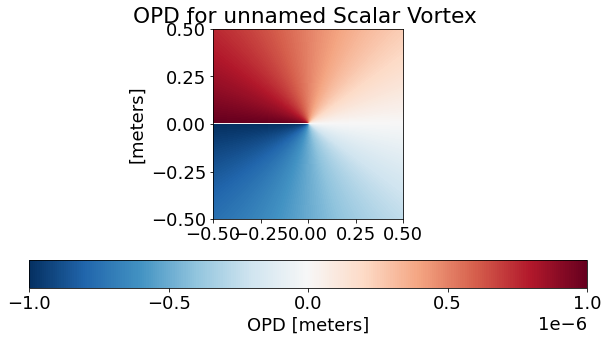

In [153]:
# Set up Coronagraph Options
from __future__ import division
import numpy as np
from poppy import AnalyticOpticalElement,FixedSamplingImagePlaneElement
from poppy.poppy_core import Wavefront, _INTERMED
from poppy import utils

import astropy.units as u

class ScalarVortexCoronagraph(AnalyticOpticalElement):
    
    def __init__(self, name="unnamed Scalar Vortex ",
                 wavelength=1e-6 * u.meter,
                 charge=2,
                 **kwargs):
        AnalyticOpticalElement.__init__(self, planetype=_INTERMED, **kwargs)
        self.name = name
        self.lp= charge
        self.central_wavelength= wavelength
        
    def getPhasor(self, wave):
        """
        Compute the amplitude transmission appropriate for a vortex for
        some given pixel spacing corresponding to the supplied Wavefront
        """

        if not isinstance(wave, Wavefront):  # pragma: no cover
            raise ValueError("AGPM getPhasor must be called with a Wavefront"
                             "to define the spacing")
        assert (wave.planetype == _IMAGE)

        y, x= self.get_coordinates(wave)
        phase = np.arctan2(y, x)

        AGPM_phasor = np.exp(1.j * self.lp * phase)

        idx= np.where(x==0)[0][0]
        idy= np.where(y==0)[0][0]
        AGPM_phasor[idx, idy]=0
        return AGPM_phasor

    def get_opd(self, wave):
        y, x= self.get_coordinates(wave)
        phase = np.arctan2(y, x)
        return self.lp * phase * self.central_wavelength.to(u.meter).value / (2 * np.pi)

    def get_transmission(self, wave):
        y, x= self.get_coordinates(wave)
        trans= np.ones(y.shape)
        return trans
        
wf = poppy.FresnelWavefront(beam_radius=1*u.m)
plt.figure(figsize=[10,5])
ScalarVortexCoronagraph().display(what='opd',opd_vmax=1e-6)
plt.show()

def propagate_NIRCam(wfarray):
    
    """
    The IWA and OWA using an EFL = 57.6m the sizes are
    IWA = 0.000264 m 5 L/D
    OWA = 0.000792 m 15 L/D
    """
    
    osys = poppy.FresnelOpticalSystem(npix=256, beam_ratio=1/4)
    
    
    # The Annular Occulting Mask
    osys.add_optic(ScalarVortexCoronagraph())
#     osys.add_optic(poppy.CircularAperture(radius=0.000264*u.m))
#     osys.add_optic(poppy.InverseTransmission(poppy.CircularAperture(radius=0.000264*u.m,name=' ')))
#     osys.add_optic((poppy.CircularAperture(radius=0.001848*u.m,name=' ')))
    
    # The Unit magnification relay 10" lens - efl is arbitrary since it's 1-1
    osys.add_optic(poppy.QuadraticLens(57.6*u.m,name=' '),distance=57.6*u.m)
    
    # The Lyot Stop
    osys.add_optic(poppy.CircularAperture(radius=2.4/2*0.2*u.m,name='Lyot Stop'),distance=57.6*u.m)
    
    osys.add_optic(poppy.QuadraticLens(57.6*u.m,name=' '),distance=57.6*u.m)
    osys.add_optic(poppy.ScalarTransmission(name=' '),distance=57.6*u.m)
    psf = osys.calc_psf(wavelength=1.65e-6*u.m,inwave=wfarray,display_intermediates=False)
    
    return psf

Oversampling > 2x suggested for reliable results in Fresnel propagation.
Oversampling > 2x suggested for reliable results in Fresnel propagation.


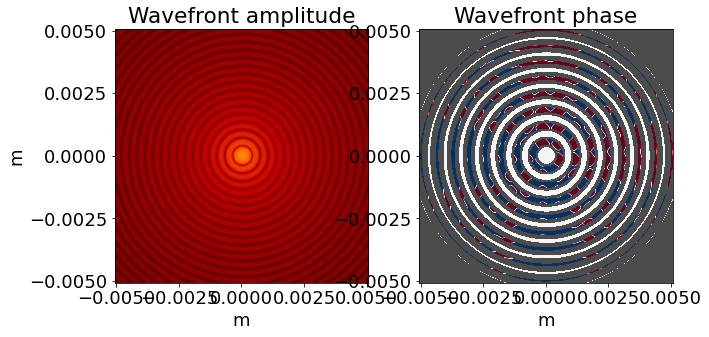

1048576.0


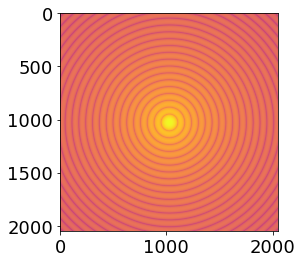

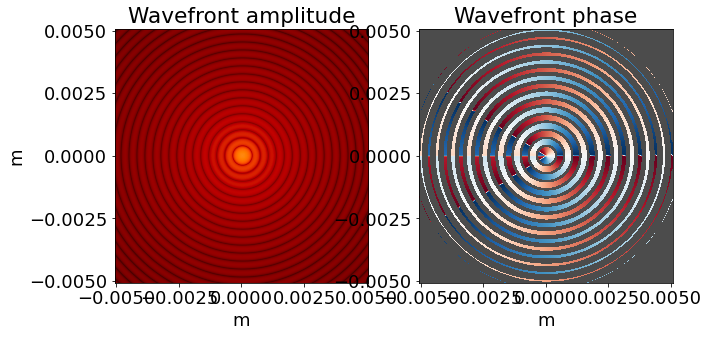

1048576.0


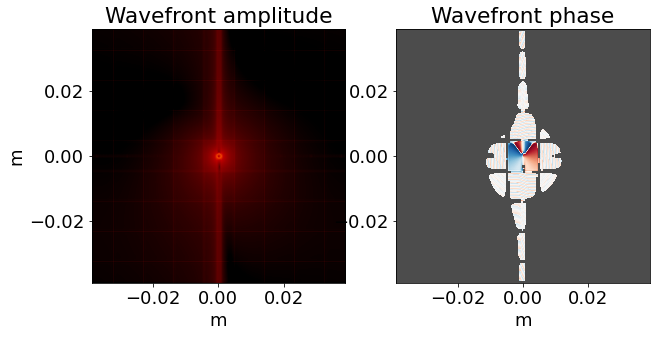

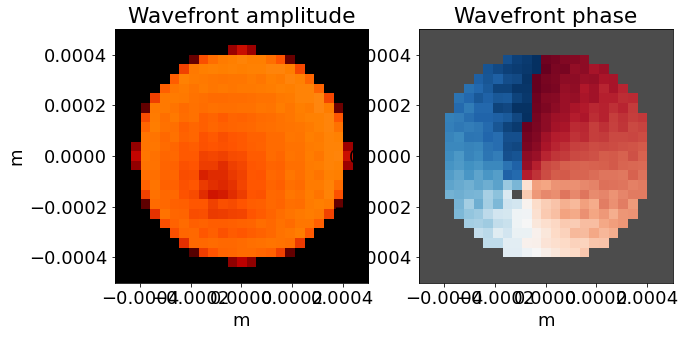

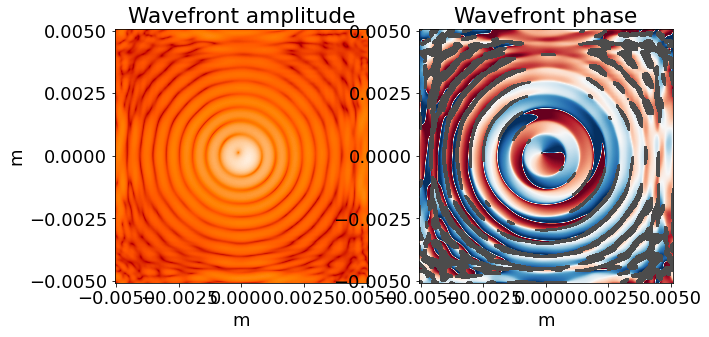

In [151]:
wfg = poppy.FresnelWavefront(beam_radius=dsize/2*u.m,npix=2048,oversample=1,wavelength=1.65e-6*u.m)
wff = poppy.FresnelWavefront(beam_radius=dsize/2*u.m,npix=2048,oversample=1,wavelength=1.65e-6*u.m)

wfg.wavefront = zoom(efie_numerical,8)
wff.wavefront = zoom(efie_fresnel,8)

wff.pixelscale = 4.95e-6 * u.m/u.pixel
wfg.pixelscale = 4.95e-6 * u.m/u.pixel

plt.figure(figsize=[10,5])
wff.display(what='both',scale='log')
plt.show()

plt.imshow(np.abs(wff.wavefront),norm=LogNorm())

wff *= ScalarVortexCoronagraph()

print(wf.total_intensity)

plt.figure(figsize=[10,5])
wff.display(what='both',scale='log')
plt.show()

dist = 254e-3

wff.propagate_fresnel(dist*u.m)
wff *= poppy.QuadraticLens(dist*u.m)
wff.propagate_fresnel(dist*u.m)

print(wf.total_intensity)

plt.figure(figsize=[10,5])
wff.display(what='both',scale='log')
plt.show()

rad = 0.001

wff *= poppy.CircularAperture(radius=rad*0.4)

plt.figure(figsize=[10,5])
wff.display(what='both',scale='log',imagecrop=0.001)
plt.show()

wff *= poppy.QuadraticLens(dist)
wff.propagate_fresnel(dist*u.m)

plt.figure(figsize=[10,5])
wff.display(what='both',scale='log',)
plt.show()

In [91]:
plt.figure(figsize=[10,5])
wff.display(what='both',scale='log',colorbar=True,normalize='sum')
plt.show()

TypeError: display() got an unexpected keyword argument 'normalize'

<Figure size 720x360 with 0 Axes>

/opt/anaconda3/lib/python3.8/site-packages/astropy/units/quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


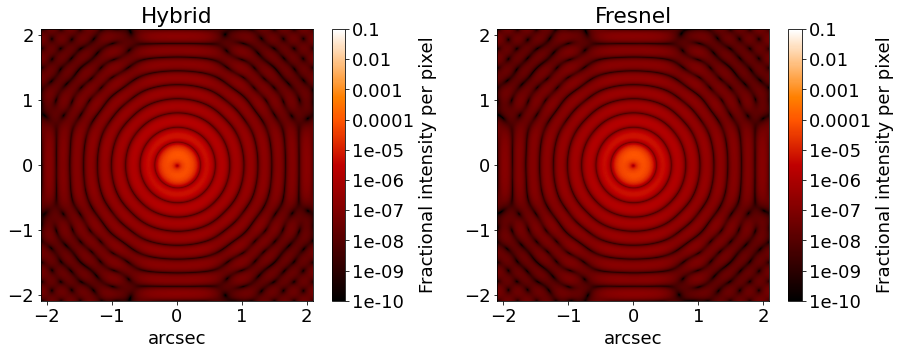

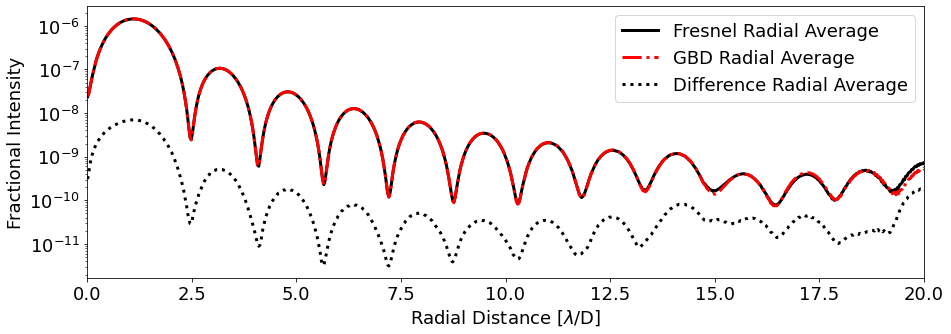

In [154]:
wfg = poppy.FresnelWavefront(beam_radius=dsize/2*u.m,npix=256,oversample=4,wavelength=2.2e-6*u.m)
wff = poppy.FresnelWavefront(beam_radius=dsize/2*u.m,npix=256,oversample=4,wavelength=2.2e-6*u.m)

wfg.wavefront = shift(zoom(efie_numerical,4),[0,-2])
wff.wavefront = shift(zoom(efie_fresnel,4),[-2,-4])

coronpsf_gbd = propagate_NIRCam(wfg)
coronpsf_fnl = propagate_NIRCam(wff)

imagec = 10

# Grab PSF data
pixscal = 206265*(4.56e-6/57.6)
gbd = array2poppyhdul(coronpsf_gbd[0].data,pixscal)
fnl = array2poppyhdul(coronpsf_fnl[0].data,pixscal)
dif = array2poppyhdul(np.abs(coronpsf_gbd[0].data - coronpsf_fnl[0].data),pixscal)

plt.figure(figsize=[15,5])
plt.subplot(121)
poppy.display_psf(gbd,imagecrop=imagec,title='Hybrid',normalize='total',vmin=1e-10) # .004
plt.subplot(122)
poppy.display_psf(fnl,imagecrop=imagec,title='Fresnel',normalize='total',vmin=1e-10)
plt.show()


fnl_pro = poppy.radial_profile(fnl)
gbd_pro = poppy.radial_profile(gbd)
dif_pro = poppy.radial_profile(dif)

pro = fnl_pro[0]/206265 * 2.4/wl

plt.figure(figsize=[15,5])
plt.plot(pro,fnl_pro[1],label='Fresnel Radial Average',color='black',linewidth=3,linestyle='solid')
plt.plot(pro,gbd_pro[1],label='GBD Radial Average',color='red',linewidth=3,linestyle='dashdot')
plt.plot(pro,dif_pro[1],label='Difference Radial Average',color='black',linewidth=3,linestyle='dotted')
plt.yscale('log')
plt.xlim([0,20])
plt.xlabel('Radial Distance [$\lambda$/D]') # '[$\lambda/D$]')
plt.ylabel('Fractional Intensity')
#plt.text(6,6,'$\sigma_d=${}'.format(np.std(ediff)))
# plt.xticks(ticks=[0,12,24,36,48],labels=[0,1.5,3,4.5,6])
plt.legend()
plt.show()

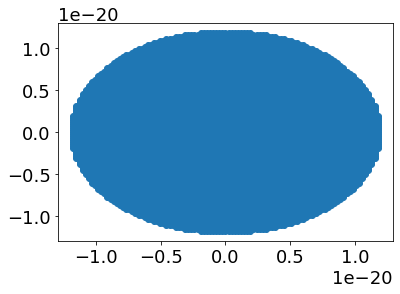

In [16]:
raysout = rt.matmultrays(ABCD,rays_aberrated)
plt.scatter(raysout[0,:],raysout[1,:])

r = np.sqrt(raysout[0,:]**2+raysout[1,:]**2)


In [17]:

wo = 2.4*1.7/202

In [18]:
wo

0.0201980198019802

In [19]:
wop = 2.4*1.7/202
wo = 9200*wl
print(wop)
print(wo)

0.0201980198019802
0.01518


In [20]:
Q = np.array([[1,2],
              [3,4]])

A = np.array([[5,6],
              [7,8]])

B = np.array([[9,10],
              [11,12]])

np.linalg.inv(A)

array([[-4. ,  3. ],
       [ 3.5, -2.5]])

In [21]:
-4*9 + 3*11 + 1

-2

In [22]:
-4*10+3*12 + 2

-2

In [23]:
-3.5*9 - 2.5*11 + 3

-56.0

In [24]:
-3.5*10-2.5*12 + 4

-61.0

In [25]:
Q + np.linalg.inv(A) @ B

array([[-2., -2.],
       [ 7.,  9.]])

In [26]:
def Inv(M):
    a = M[0,0]
    b = M[0,1]
    c = M[1,0]
    d = M[1,1]

    return 1/(a*d - b*c)*np.array([[d,-b],
                                   [-c,a]])

def Det(M):
    a = M[0,0]
    b = M[0,1]
    c = M[1,0]
    d = M[1,1]

    return (a*d-b*c)

def Mult(M1,M2):

    a1 = M1[0,0]
    b1 = M1[0,1]
    c1 = M1[1,0]
    d1 = M1[1,1]

    a2 = M2[0,0]
    b2 = M2[0,1]
    c2 = M2[1,0]
    d2 = M2[1,1]

    A = a1*a2 + b1*c2
    B = a1*b2 + b1*d2
    C = c1*a2 + d1*c2
    D = c1*b2 + d1*d2

    mat = np.array([[A,B],[C,D]])

    return mat

In [27]:
Q + Mult(Inv(A),B)

array([[-2., -2.],
       [ 7.,  9.]])

In [28]:
!pip install poppy==1.0.0

  Using cached poppy-1.0-py3-none-any.whl
Reason for being yanked: accidental pre-release (wait for 1.0.0)
  Attempting uninstall: poppy
    Found existing installation: poppy 1.0.2
    Uninstalling poppy-1.0.2:
      Successfully uninstalled poppy-1.0.2


In [29]:
import importlib
importlib.reload(poppy)
import poppy

In [30]:
!pip install poppy==1.0.2

  Using cached poppy-1.0.2-py3-none-any.whl
  Attempting uninstall: poppy
    Found existing installation: poppy 1.0
    Uninstalling poppy-1.0:
      Successfully uninstalled poppy-1.0


In [31]:
57.6*35*wl/2.4

0.001386

In [32]:
253e-3*(2.4/57.6)

0.010541666666666666

In [33]:
def ComputeGouyPhase(Q):

    eigvals = np.linalg.eigvals(Q)
    q1,q2 = eigvals[0],eigvals[1]

    gouy = .5*(np.arctan(np.real(q1)/np.imag(q1)) + np.arctan(np.real(q2)/np.imag(q2)))

    return gouy

def PropagateQ(Q,abcd):
    A = abcd[0:2,0:2]
    B = abcd[0:2,2:4]
    C = abcd[2:4,0:2]
    D = abcd[2:4,2:4]
    
    Qp = (C + D @ Q) * np.linalg.inv(A + B @ Q)
    return Qp

# Artificial ABCD appears to work as expected!
efl = 57.6
dis = 57.6
abcd = np.array([[1-dis/efl + 1e-20,0,dis,0],
                 [0,1-dis/efl + 1e-20,0,dis],
                 [-1/efl,0,1,0],
                 [0,-1/efl,0,1]])






guoy = ComputeGouyPhase(np.linalg.inv(PropagateQ(Qinv,abcd)))
print(guoy)

0.07331609395587936
